# Predict all cause 30-day hospital readmission risk

### Importing the required libraries

In [ ]:
!pip install ipython-autotime

In [1]:
# Importing libs into the python environment. These functions will be referenced later in the notebook code.

from __future__ import print_function
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Put this when it's called
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report



# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data*100

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")
    plt.legend(loc="best")
    return plt


# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)
    
## Plot Precision Recall threshold curve  
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

## plot_precision_recall_vs_threshold
    def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        plt.figure(figsize=(8, 8))
        plt.title("Precision and Recall Scores as a function of the decision threshold")
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
        plt.ylabel("Score")
        plt.xlabel("Decision Threshold")
        plt.legend(loc='best')

# Thinking about Data

It is important to understand the relationship between different tables and the data in those tables. This is important to identify the information which is relevant to the prediction. Here is the schema.

## Cleaning and Visualizing Your Data

<img src="EHR.png">

In [2]:
import boto3
import botocore 
bucket = 'readmission-data' # Update this to the bucket that was created in your lab account as part of this enviroment.
prefix = "train_data/"
 
s3 = boto3.resource('s3')

Load the Pickle file into a Pandas Dataframe

In [3]:
## As a next step, we can use trusted pickle to check for signature on pickle dump when it is read to avoid spoofing
import pickle
s3.Bucket(bucket).download_file('processed-data/readmission-processed-data.pkl', 'readmission-processed-data.pkl')
df_ft_select_category = pickle.load(open('readmission-processed-data.pkl', 'rb'))

In [4]:
#plot Confusion Matrix function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.savefig("confusionmatrix.png")
    plt.close()


# end Confusion Matrix function


# ROC Curve Plotting function

def plot_roc_curve(fpr,tpr):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

#end ROC plotting function


# Precision Recall (PR) function
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.show( )
    plt.close()

#end PR function

## Grid Search Wrapper function
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search
## End Grid Search wrapper function


In [5]:
X_train = df_ft_select_category[df_ft_select_category.columns.difference(['readmission'])]
Y_train = df_ft_select_category['readmission']
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=0)


# show the train and test distribution
print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))


y_train class distribution
0    0.918804
1    0.081196
Name: readmission, dtype: float64
y_test class distribution
0    0.918832
1    0.081168
Name: readmission, dtype: float64


In [6]:
## Sampling data for balanced positives and negatives
# shuffle the samples
df_ft_select_category = df_ft_select_category.sample(n = len(df_ft_select_category), random_state = 42)
df_ft_select_category = df_ft_select_category.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_ft_select_category.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_ft_select_category.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.readmission.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.readmission.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.readmission.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_ft_select_category))
assert len(df_ft_select_category) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 2294293): 0.08100185983220103
Valid prevalence(n = 2294293): 0.08097788730558826
Train all prevalence(n = 10706699): 0.08127257523537366
all samples (n = 15295285)


In [7]:
# split the training data into positive and negative
rows_pos = df_train_all.readmission == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)


print('Train prevalence (n = %d):'%len(df_train), df_train.readmission.sum()/ len(df_train))

Train prevalence (n = 1740322): 0.5


In [ ]:
# Logistic Regression Model

## Since number of negatives samples are higher than positive samples so balancing the data 
Y_train = df_train['readmission']
X_train = df_train[df_train.columns.difference(['readmission'])]
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=0)

logisticRegr = LogisticRegression(random_state=0, solver='lbfgs',
multi_class='multinomial', max_iter=1000)
logisticRegr.fit(x_train, y_train)
y_test_pred_LR = cross_val_predict(logisticRegr, x_test, y_test, cv=3)
score = logisticRegr.score(x_test, y_test)
y_test_pred = y_test_pred_LR
print("LR Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
print("Classification Report")
print("="*50)
LR_CR = classification_report(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
  title='Confusion matrix, without normalization')
    
# Compute ROC curve and ROC area
#fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
  

    
logit_roc_auc = roc_auc_score(y_test_pred, logisticRegr.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression ' ) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
plt.show()


title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')
plot_learning_curve(estimator, title, x_train, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
# SVM Model

sgd_clf = SGDClassifier(random_state=0, loss="log", max_iter=1000, tol=3 )
sgd_clf.fit(x_train, y_train)
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")
y_test_pred_SVC = cross_val_predict(sgd_clf, x_test, y_test, cv=3)
predictions = sgd_clf.predict(x_test)
score = sgd_clf.score(x_test, y_test)
y_test_pred = y_test_pred_SVC
print("SVM Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred_SVC)
print("roc score", roc)
SVM_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(SVM_CR)
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
  title='Confusion matrix, without normalization')
    
# Compute micro-average ROC curve and ROC area
fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
  
    
roc_auc = roc_auc_score(y_test_pred, sgd_clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, sgd_clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM  ' ) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

precision_recall_curve()

In [ ]:
## XGBoost - Sagemaker Native 


In [ ]:
# Random Forest Model with original sampling data
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=42, n_estimators=100)
RF.fit(x_train, y_train)
cross_val_score(RF, x_train, y_train, cv=3, scoring="accuracy")
y_test_pred_RF = cross_val_predict(RF, x_test, y_test, cv=3)
predictions = RF.predict(x_test)
score = RF.score(x_test, y_test)
y_test_pred = y_test_pred_RF
print("RF Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
RF_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(RF_CR)
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    
# Compute micro-average ROC curve and ROC area
fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
 
roc_auc = roc_auc_score(y_test_pred, RF.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, RF.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest ' )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("randonforest-roc-auc-curve.png")
plt.show()

## Precision Recall Curve 
y_score_rf = RF.predict_proba(x_test)[:,-1]
average_precision = average_precision_score(y_test, y_score_rf)
print('Average precision-recall score RF: {}'.format(average_precision))
precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# decision thresholds plot
plot_precision_recall_vs_threshold(precision, recall, thresholds)

RF Accuracy 0.8566090209290611
roc score 0.8566192522759817
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.84      0.85    261187
           1       0.84      0.88      0.86    260910

    accuracy                           0.86    522097
   macro avg       0.86      0.86      0.86    522097
weighted avg       0.86      0.86      0.86    522097

Confusion matrix, without normalization
[[218701  42486]
 [ 32378 228532]]


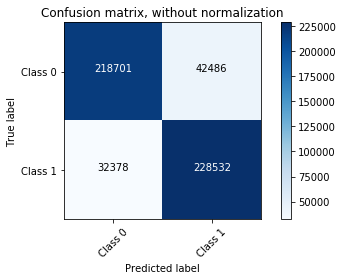

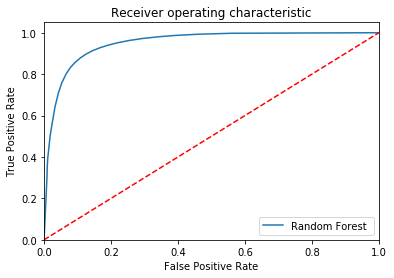

Average precision-recall score RF: 0.9377977522694572


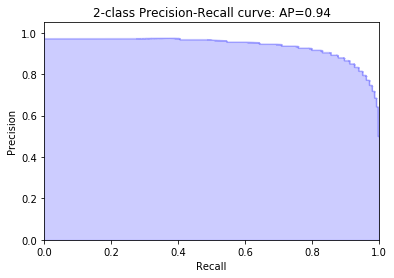

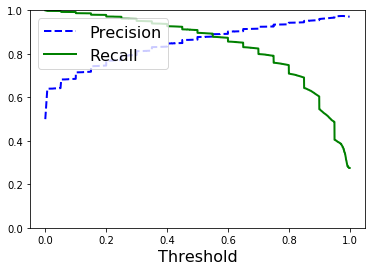

In [8]:
## Random Forest Model with overfitting data
## This is giving incorrect results. It's predicting that certain procedures require readmission but when validated 
## with the data, it was not the case. For example 

X_train = df_train[df_train.columns.difference(['readmission'])]
Y_train = df_train['readmission']
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=0)

from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=42, n_estimators=20)
RF.fit(x_train, y_train)
cross_val_score(RF, x_train, y_train, cv=3, scoring="accuracy")
y_test_pred_RF = cross_val_predict(RF, x_test, y_test, cv=3)
predictions = RF.predict(x_test)
score = RF.score(x_test, y_test)
y_test_pred = y_test_pred_RF
print("RF Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
RF_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(RF_CR)
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    
# Compute micro-average ROC curve and ROC area
fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
 
roc_auc = roc_auc_score(y_test_pred, RF.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, RF.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest ' )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("randonforest-roc-auc-curve.png")
plt.show()


## Precision Recall Curve 
y_score_rf = RF.predict_proba(x_test)[:,-1]
average_precision = average_precision_score(y_test, y_score_rf)
print('Average precision-recall score RF: {}'.format(average_precision))
precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# decision thresholds plot
plot_precision_recall_vs_threshold(precision, recall, thresholds)


In [ ]:
## Multi-Layer Perceptron (NN) classification
mlp = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
mlp.fit(x_test, y_test)

cross_val_score(mlp, x_train, y_train, cv=3, scoring="accuracy")

y_test_pred_NN = cross_val_predict(mlp, x_test, y_test, cv=3)
predictions = mlp.predict(x_test)
score = mlp.score(x_test, y_test)

y_test_pred = y_test_pred_NN
print("NN Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
NN_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(NN_CR)
    
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
  title='Confusion matrix, without normalization') 

# Compute micro-average ROC curve and ROC area
fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
roc_auc  = auc(fpr , tpr )
  
 
    
     
roc_auc = roc_auc_score(y_test_pred, mlp.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='MLP  '  )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
## GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(x_train, y_train)

cross_val_score(gb_clf, x_train, y_train, cv=3, scoring="accuracy")
y_test_pred_gb = cross_val_predict(gb_clf, x_test, y_test, cv=3)
predictions = gb_clf.predict(x_test)
score = gb_clf.score(x_test, y_test)
y_test_pred = y_test_pred_gb
print("GB Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
GB_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(GB_CR)
    
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
  title='Confusion matrix, without normalization')
  
    
# Compute micro-average ROC curve and ROC area
fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
roc_auc  = auc(fpr , tpr )
 
 
roc_auc = roc_auc_score(y_test_pred, gb_clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, gb_clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting  '  )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
     
plt.show()

## Precision Recall Curve 
y_score_rf = gb_clf.predict_proba(x_test)[:,-1]
average_precision = average_precision_score(y_test, y_score_rf)
print('Average precision-recall score RF: {}'.format(average_precision))
precision, recall, _ = precision_recall_curve(y_test, y_score_rf)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
# Decision Tree Model
DT = DecisionTreeClassifier(random_state=42)
DT.fit(x_train, y_train)
cross_val_score(DT, x_train, y_train, cv=3, scoring="accuracy")
y_test_pred_DT = cross_val_predict(DT, x_test, y_test, cv=3)
predictions = DT.predict(x_test)
score = DT.score(x_test, y_test)
y_test_pred = y_test_pred_DT
print("DT Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
DT_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(DT_CR)
# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
  title='Confusion matrix, without normalization')
    
# Compute micro-average ROC curve and ROC area
fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
 
    
roc_auc = roc_auc_score(y_test_pred, DT.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, DT.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree '  )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
     
plt.show()

In [10]:
## After analysis of the different models, it is found that Randon Forest Model fits best on the current data set 
## As a next step, Identifying the significant features in the model
feature_list = list(x_train.columns)


# Get numerical feature importances
importances = list(RF.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: providers_utilization Importance: 0.17
Variable: organizations_revenue Importance: 0.15
Variable: patient_healthcare_coverage Importance: 0.08
Variable: patient_healthcare_expenses Importance: 0.07
Variable: age                  Importance: 0.06
Variable: procedures_base_cost Importance: 0.06
Variable: encounters_code_424441002 Importance: 0.05
Variable: encounters_payer_coverage Importance: 0.02
Variable: procedures_code_225158009.0 Importance: 0.02
Variable: encounters_code_185345009 Importance: 0.01
Variable: encounters_code_185347001 Importance: 0.01
Variable: encounters_code_185349003 Importance: 0.01
Variable: encounters_code_371883000 Importance: 0.01
Variable: encounters_code_390906007 Importance: 0.01
Variable: encounters_code_424619006 Importance: 0.01
Variable: encounters_code_702927004 Importance: 0.01
Variable: encounters_encounterclass_inpatient Importance: 0.01
Variable: encounters_encounterclass_outpatient Importance: 0.01
Variable: encounters_encounterclass_u

In [ ]:
# List of tuples with variable and importance
for pair in feature_importances:
    if pair[1] > 0:
        print (pair)

In [ ]:
import csv
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
with open('significant_features.csv', 'w') as feature_file:
    file_writer = csv.writer(feature_file)
    item_length = len(feature_importances[0])
    file_writer.writerow(['significant_feature','importance'])
    for pair in feature_importances:
        if pair[1] > 0:
            print (pair)
            file_writer.writerow(pair)
s3.Bucket(bucket).upload_file('significant_features.csv','processed-data/significant_features.csv',ExtraArgs={"ServerSideEncryption": "aws:kms","SSEKMSKeyId":"3a90a5d2-2ba8-4942-b9df-9a27ff7bf412" })


        

In [ ]:
## Hyperparameter tuning of Random Forest Model
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(x_train, y_train)
# print results
print(rfc_random.best_params_)

In [11]:
s3.Bucket(bucket).download_file('batch-transform/processed-data/readmission-predict-input-data.pkl', 'readmission-predict-input-data.pkl')
x_test_temp = pickle.load(open('readmission-predict-input-data.pkl', 'rb'))
x_test_temp.head(10)

,patient_healthcare_expenses,patient_healthcare_coverage,encounters_total_claim_cost,encounters_payer_coverage,encounters_base_encounter_cost,procedures_base_cost,organizations_revenue,providers_utilization,age,encounters_encounterclass_emergency,...,procedures_code_714812005.0,procedures_code_715252007.0,procedures_code_1571000087109.0,procedures_code_112011000119102.0,procedures_code_426701000119108.0,procedures_code_428191000124101.0,procedures_code_755621000000101.0,procedures_code_1015401000000102.0,procedures_code_1.6335031000119104e+16,providers_speciality_M
0,17417.72,1141.80,129.16,0.00,129.16,0.00,0.00,0.00,36,0,...,0,0,0,0,0,0,0,0,0,1
1,1378792.06,14478.94,129.16,64.16,129.16,17366.59,17366.59,17366.59,67,0,...,0,0,0,0,0,0,0,0,0,1
2,321771.74,35745.71,129.16,0.00,129.16,0.00,0.00,0.00,82,0,...,0,0,0,0,0,0,0,0,0,1
3,1324925.75,4326.08,129.16,49.16,129.16,516.65,516.65,516.65,82,0,...,0,0,0,0,0,0,0,0,0,1
4,1324925.75,4326.08,129.16,49.16,129.16,516.65,516.65,516.65,82,0,...,0,0,0,0,0,0,0,0,0,1
5,194218.34,9645.96,129.16,69.16,129.16,0.00,0.00,0.00,82,0,...,0,0,0,0,0,0,0,0,0,1
6,224775.07,16172.98,129.16,69.16,129.16,16079.75,16079.75,16079.75,82,0,...,0,0,0,0,0,0,0,0,0,1
7,801505.01,3389.61,129.16,0.00,129.16,0.00,0.00,0.00,36,1,...,0,0,0,0,0,0,0,0,0,1
8,801505.01,3389.61,129.16,0.00,129.16,0.00,0.00,0.00,36,1,...,0,0,0,0,0,0,0,0,0,1
9,643434.77,10179.76,129.16,64.16,129.16,4674.72,4674.72,4674.72,29,1,...,0,0,0,0,0,0,0,0,0,1


In [17]:
feature_difference = X_train - x_test_temp
feature_difference_df = pd.DataFrame(data=np.zeros((x_test_temp.shape[0], len(feature_difference))),
                                     columns=list(feature_difference))
# add "missing" features back to `test
x_test_temp = x_test_temp.join(feature_difference_df)

#x_test_temp.info()
feature_difference_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297341 entries, 0 to 297340
Empty DataFrame

In [29]:
## Dropping the features which are present in test but not in training data  
feature_difference = set(x_test_temp.columns).difference(set(X_train.columns))
for feature in feature_difference:
    print (feature)

x_test_temp2 = x_test_temp.drop(columns=feature_difference)
x_test_temp2

encounters_code_410620009
encounters_code_162673000
encounters_encounterclass_wellness
encounters_code_308646001


,patient_healthcare_expenses,patient_healthcare_coverage,encounters_total_claim_cost,encounters_payer_coverage,encounters_base_encounter_cost,procedures_base_cost,organizations_revenue,providers_utilization,age,encounters_encounterclass_emergency,...,encounters_reasoncode_200936003,encounters_reasoncode_225444004,patient_race_other,procedures_code_90407005.0,procedures_code_88848003.0,procedures_code_48387007.0,procedures_code_180030006.0,procedures_code_305425002.0,encounters_reasoncode_86849004,encounters_reasoncode_287185009
0,17417.72,1141.80,129.16,0.00,129.16,0.00,0.00,0.00,36,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1378792.06,14478.94,129.16,64.16,129.16,17366.59,17366.59,17366.59,67,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,321771.74,35745.71,129.16,0.00,129.16,0.00,0.00,0.00,82,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1324925.75,4326.08,129.16,49.16,129.16,516.65,516.65,516.65,82,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1324925.75,4326.08,129.16,49.16,129.16,516.65,516.65,516.65,82,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,194218.34,9645.96,129.16,69.16,129.16,0.00,0.00,0.00,82,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,224775.07,16172.98,129.16,69.16,129.16,16079.75,16079.75,16079.75,82,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,801505.01,3389.61,129.16,0.00,129.16,0.00,0.00,0.00,36,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,801505.01,3389.61,129.16,0.00,129.16,0.00,0.00,0.00,36,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,643434.77,10179.76,129.16,64.16,129.16,4674.72,4674.72,4674.72,29,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
predictions_temp = RF.predict(x_test_temp2)

In [51]:
predictions_temp_df = pd.DataFrame(predictions_temp)
predictions_temp_df = predictions_temp_df.rename(columns={0: "readmission"})
predictions_temp_df.describe()

,readmission
count,297341.000000
mean,0.000081
std,0.008984
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [34]:
##df_first_merge = pd_read_s3_multiple_parquets(prefix, bucket)
import boto3
import botocore 
import io
bucket = 'readmission-data' # Update this to the bucket that was created in your lab account as part of this enviroment.
prefix = "batch-transform/output"
 
s3 = boto3.resource('s3')

import s3fs
import pyarrow.parquet as pq
from pyarrow.filesystem import S3FSWrapper

fs = s3fs.S3FileSystem()


# Python 3.6 or later
p_dataset = pq.ParquetDataset(
    f"s3://{bucket}/{prefix}",
    filesystem=fs
)
original_test_df = p_dataset.read().to_pandas()

original_test_df.head()


,patient_healthcare_expenses,encounters_encounterclass,encounters_id,patient_gender,patient_healthcare_coverage,patient_marital,encounters_total_claim_cost,patient_ethnicity,patient_id,encounters_code,...,encounters_reasoncode,procedures_code,procedures_base_cost,medications_base_cost,medications_totalcost,organizations_id,organizations_revenue,providers_speciality,providers_state,providers_utilization
0,17417.72,outpatient,63f652bc-bd5a-4efd-9894-66f760a89789,F,1141.80,M,129.16,american,94a52e2c-c2f1-4c64-a7b5-b601e2294949,698314001,...,0,NaN,NaN,36.47,437.64,03347b4d-994e-302b-848b-58019a4e274d,184569.64,M,MA,1456.0
1,1378792.06,ambulatory,747a4ad4-c6b9-483b-bd44-f8a40f7fc224,F,14478.94,M,129.16,west_indian,80ca2ea1-a3b5-4f99-9d4c-d00bb66ddf7e,185347001,...,363406005,703423002.0,17366.59,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,184569.64,M,MA,1456.0
2,321771.74,outpatient,ba5ecdc6-86d1-4772-a9fc-1355644233e1,M,35745.71,M,129.16,german,34d1f315-2f26-43bf-b773-ad2b75c3d4b8,185349003,...,0,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,184569.64,M,MA,1456.0
3,1324925.75,ambulatory,f721e9fc-6584-4b71-b137-29d7fca740dd,M,4326.08,M,129.16,english,b3ac5384-e415-4015-83ec-96cf73b3f8a2,185347001,...,88805009,NaN,516.65,263.49,3161.88,03347b4d-994e-302b-848b-58019a4e274d,184569.64,M,MA,1456.0
4,1324925.75,ambulatory,f721e9fc-6584-4b71-b137-29d7fca740dd,M,4326.08,M,129.16,english,b3ac5384-e415-4015-83ec-96cf73b3f8a2,185347001,...,88805009,NaN,516.65,263.49,2634.90,03347b4d-994e-302b-848b-58019a4e274d,184569.64,M,MA,1456.0


In [52]:
prediction_data = original_test_df[['patient_id','encounters_id','encounters_code','procedures_code','patient_gender','patient_ethnicity','organizations_id']]
prediction_data_combine = pd.concat([prediction_data, predictions_temp_df], axis=1)
prediction_data_combine.head(20)

,patient_id,encounters_id,encounters_code,procedures_code,patient_gender,patient_ethnicity,organizations_id,readmission
0,94a52e2c-c2f1-4c64-a7b5-b601e2294949,63f652bc-bd5a-4efd-9894-66f760a89789,698314001,NaN,F,american,03347b4d-994e-302b-848b-58019a4e274d,0
1,80ca2ea1-a3b5-4f99-9d4c-d00bb66ddf7e,747a4ad4-c6b9-483b-bd44-f8a40f7fc224,185347001,703423002.0,F,west_indian,03347b4d-994e-302b-848b-58019a4e274d,0
2,34d1f315-2f26-43bf-b773-ad2b75c3d4b8,ba5ecdc6-86d1-4772-a9fc-1355644233e1,185349003,NaN,M,german,03347b4d-994e-302b-848b-58019a4e274d,0
3,b3ac5384-e415-4015-83ec-96cf73b3f8a2,f721e9fc-6584-4b71-b137-29d7fca740dd,185347001,NaN,M,english,03347b4d-994e-302b-848b-58019a4e274d,0
4,b3ac5384-e415-4015-83ec-96cf73b3f8a2,f721e9fc-6584-4b71-b137-29d7fca740dd,185347001,NaN,M,english,03347b4d-994e-302b-848b-58019a4e274d,0
5,8932eae1-cb01-4b43-995d-6122d01dbc0f,f8eec2fe-d2da-4d73-a027-c58a10c20937,185347001,NaN,M,german,03347b4d-994e-302b-848b-58019a4e274d,0
6,8ade40fe-6920-47c7-9067-021cd800f61a,fe40b1d4-88be-4e51-add3-7649bde08c24,185349003,73761001.0,M,german,03347b4d-994e-302b-848b-58019a4e274d,0
7,4c9340cc-1b8c-4f74-8c94-042bd2c8bd1f,4b2735b8-e168-4f36-9f03-dd74a49687ac,50849002,NaN,M,puerto_rican,03347b4d-994e-302b-848b-58019a4e274d,0
8,4c9340cc-1b8c-4f74-8c94-042bd2c8bd1f,4b2735b8-e168-4f36-9f03-dd74a49687ac,50849002,NaN,M,puerto_rican,03347b4d-994e-302b-848b-58019a4e274d,0
9,b1c1e406-379c-4205-ada8-3483499f7fff,5fda5b79-76ce-40e1-9798-e2a469e9d047,183460006,237001001.0,F,greek,03347b4d-994e-302b-848b-58019a4e274d,0


In [90]:
## Find out high risk patients
high_risk_patient = prediction_data_combine[prediction_data_combine['readmission'] == 1]


In [65]:
high_risk_patient_csv = high_risk_patient.to_csv(index=False,header=True)
with open('preditions.csv', 'w') as prediction_file:
    prediction_file.write(high_risk_patient_csv)
prediction_file.close()
s3.Bucket(bucket).upload_file('preditions.csv','batch-transform/prediction/preditions.csv',ExtraArgs={"ServerSideEncryption": "aws:kms","SSEKMSKeyId":"3a90a5d2-2ba8-4942-b9df-9a27ff7bf412" })


In [108]:
## Adding entries to Dynamodb for patients
import boto3
from datetime import datetime
dateTimeObj = datetime.now()
table = boto3.resource('dynamodb').Table('readmission-prediction')
patients = high_risk_patient['patient_id']
for patient in patients: 
    response = table.update_item(
        Key={
            "patient_id" : patient,
        },
        UpdateExpression='SET readmission = :val1',
        ExpressionAttributeValues={
            ':val1': 'Y'
        }
    )
    print (response)

{'ResponseMetadata': {'RequestId': 'P9GEHU425GBE8UFEGS7AUT7AC7VV4KQNSO5AEMVJF66Q9ASUAAJG', 'HTTPStatusCode': 200, 'HTTPHeaders': {'server': 'Server', 'date': 'Mon, 21 Oct 2019 06:02:40 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'P9GEHU425GBE8UFEGS7AUT7AC7VV4KQNSO5AEMVJF66Q9ASUAAJG', 'x-amz-crc32': '2745614147'}, 'RetryAttempts': 0}}
{'ResponseMetadata': {'RequestId': 'FT8EKJ92OK4P7SGJ2P8DNL0S97VV4KQNSO5AEMVJF66Q9ASUAAJG', 'HTTPStatusCode': 200, 'HTTPHeaders': {'server': 'Server', 'date': 'Mon, 21 Oct 2019 06:02:40 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'FT8EKJ92OK4P7SGJ2P8DNL0S97VV4KQNSO5AEMVJF66Q9ASUAAJG', 'x-amz-crc32': '2745614147'}, 'RetryAttempts': 0}}
{'ResponseMetadata': {'RequestId': '7G7QC8FSM6QLTGLDL9LNM8NIQ3VV4KQNSO5AEMVJF66Q9ASUAAJG', 'HTTPStatusCode': 200, 'HTTPHeaders': {'server': 'Server', 'date': 'Mon, 21 Oct